# Part 2

## Which are the worst and best represented countries in the research?

In this section we convert the documents into a usable *DataFrame* in order to figure out the countries that are most and less active in the research.<br>

We do this by looking the country of the authors and the universities (affiliations).<br>


In [1]:
#importing libraries
import nltk 
import dask
from dask.distributed import Client, progress, SSHCluster
import dask.bag as db
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
import time
import tornado
import re
import os
import asyncssh
import sys
import paramiko
import distributed

import warnings
warnings.filterwarnings("ignore")

### Create a Cluster

In [2]:
def Cluster( nprocs, nthreads=1,memory_limit="1GB", n_core_VM=4): #number_nodes=3,
    
    scheduler = "10.67.22.84"
    nodes = ["10.67.22.84", "10.67.22.254", "10.67.22.111"]
    #workers = 0
    
    if nprocs <= n_core_VM: 
        string = ("-"+ nodes[0]) *(nprocs)
        workers = string[1:].split("-")
    elif nprocs <= 2*n_core_VM:
        string = ("-"+ nodes[0])*(n_core_VM) + ("-"+ nodes[1])*(nprocs-n_core_VM)
        workers = string[1:].split("-")
    elif nprocs <= 3*n_core_VM:
        string = ("-"+ nodes[0])*(n_core_VM) +("-"+ nodes[1])*(n_core_VM) +("-"+ nodes[2])*(nprocs-2*n_core_VM)
        workers = string[1:].split("-")
    else:
        print("Warning: Too much cores selected ---> Set all cores available.")
        string = ("-"+ nodes[0])*(n_core_VM) +("-"+ nodes[1])*(n_core_VM) +("-"+ nodes[2])*(nprocs-2*n_core_VM)
        workers = string[1:].split("-")
        
    workers.insert( 0 , scheduler )   
    
    memory = [c for c in memory_limit]
    
    c = SSHCluster( workers,
            connect_options={"known_hosts": None},
            worker_options={"nthreads" : nthreads, "memory_limit":memory_limit},
            scheduler_options={"port": 8786, "dashboard_address": 8787 },
          )  
    
    return c

 
#  Function that close the client and kill also the background processes ID related to dask
#  becouse there is a little bug that doesn't allow to properly close the scheduler using
#  "client.shutdown".  We use a bash script that kill every process of dask both scheduler 
#  and workers; it's usefull when is necessary to execute the same computation changing 
#  the number of workers.

def dask_close_all(): 
    client.close()
    client.shutdown()
    !kill $(ps aux | grep '[d]istributed.cli.dask' | awk '{print $2}')
    !sh data/clusters_script/close_dask.sh


In [3]:
# Start a client
cluster = Cluster (nprocs=12, nthreads=1)
client = Client(cluster)
client

distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:42575'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:36620'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:43202'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

Client Scheduler: tcp://10.67.22.84:8786 Dashboard: http://10.67.22.84:8787/status,Cluster Workers: 12 Cores: 12 Memory: 11.18 GiB


In [4]:
#dask_close_all()

### Convert the documents in a usable DataFrame data structure

First of all, *Dask DataFrames* expects data that is organized as flat columns. It does not support nested JSON data very well.
For this reason we use *Dask Bag* to flatten down our nested data structure, map that across our records, and then convert that to a *Dask DataFrame*.

In order to convert the papers in a *DataFrame* data structure, we have looked at "*metadata" $\rightarrow$ "authors*" fields in each document and since we are interested only on the "*country*" and "*institution*" fields we keep only these entries.

In [4]:
# Load database with all .json files as a Dask Bag
b = db.read_text('./data/1000papers_json_singleline/*.json').map(json.loads) # 1 partition for each file
b

dask.bag<loads, npartitions=1000>

In [5]:
#An example of the paper from the bag
b.pluck('metadata').take(1)

({'title': 'Journal Pre-proofs The Fire This Time: The Stress of Racism, Inflammation and COVID-19',
  'authors': [{'first': 'Olusola',
    'middle': [],
    'last': 'Ajilore',
    'suffix': '',
    'affiliation': {'laboratory': '',
     'institution': 'University of Illinois at Chicago',
     'location': {'settlement': 'Chicago', 'region': 'IL', 'country': 'USA'}},
    'email': 'oajilore@uic.edu'},
   {'first': 'April',
    'middle': ['D'],
    'last': 'Thames',
    'suffix': '',
    'affiliation': {'laboratory': '',
     'institution': 'University of Southern California',
     'location': {'addrLine': '1601 W. Taylor Street',
      'postCode': '60612',
      'settlement': 'Los Angeles, Chicago',
      'region': 'CA, IL',
      'country': 'USA'}},
    'email': ''}]},)

In [6]:
country_list_b = (b.pluck('metadata').pluck('authors').repartition(50).flatten()
                .filter(lambda record: bool(record['affiliation']))  #drop missing 'affilation'
                .filter(lambda record: bool(record['affiliation']['location'])) #drop missing 'location'
                .pluck('affiliation').pluck('location')
                .map(lambda record: record['country'] if 'country' in record.keys()  else None) )
country_list_b

dask.bag<lambda, npartitions=50>

In [7]:
%%time 
country_list = country_list_b.compute()

CPU times: user 228 ms, sys: 9.69 ms, total: 238 ms
Wall time: 1.25 s


In [8]:
unique_country_list = list(set(country_list))
unique_country_list

['Deutschland',
 'Guatemala',
 'Chile, Chile',
 'Italy, Canada',
 'Afghanistan',
 'Connecticut',
 'Malta',
 'Australia, PR China',
 'Denmark',
 'Jordan',
 'Indonesia',
 'France',
 'China. King',
 'Alabama',
 'USA, USA',
 'Slovenia',
 'Taiwan, ROC',
 'Zambia',
 'United States',
 'Czech Republic',
 'Ireland',
 'the Netherlands',
 "People's Republic of China",
 'China. ✉',
 'Qatar, Qatar',
 'United Arab, UAE',
 'P.R.China',
 'Italia',
 'Cameroon',
 'France;, India',
 'Peru',
 'Canada, Canada',
 'Brazil, Brazil',
 'Japan, Japan',
 'Australia',
 'Greece',
 'Spain (O. Nicolás), Spain (',
 'Iran',
 'Uzbekistan',
 'Malta;, Malta',
 'Switzerland',
 'Canada, India',
 'Colombia',
 'Japan',
 'Belgium',
 'Italy; 16',
 'Tunisia',
 'USA',
 'Michigan',
 'Albania',
 'South Korea',
 'France, France',
 'Portugal',
 'Italy;',
 'Estonia',
 'Italy Correspondence, Germany',
 'Brazil',
 'Israel',
 'South Africa',
 'China., China',
 'Russia, India, China',
 'United Arab Emirates',
 'Nepal',
 'United States of 

We notice that inside the " *author $\rightarrow$ affiliation $\rightarrow$ location $\rightarrow$ country* " values there could be reported more than only one country and we want to count all of them. Sometimes also the name of the country is repeated, mispelled or written with synonims or in other ways.<br>

We find that the maximum number of countries for each author is 3 and for this reason we store the countries name <br>( "*Country1*", "*Country2*", "*Country3*" ) in a *DataFrame* along with the name and the university ("*institution*") of each author.

In order to clean all the "*country*" entries before putting in the *DataFrame*, we've built two functions:<br>
- **`clean_countries `**: remove all the wrong characters (symbols, numbers, ...) using *RegEX* module as before, split if more than one country is reported and remove repetitions. It returns a list of two strings.


- **`check_name_country`**: correct the names of the country in the list if it's wrong (comparing a database contained in "*countries.txt*") and also check if the reported name is actually a country, otherwise insert *None* <br>

We have downloaded a database ("*countries.txt*": https://gist.github.com/kalinchernev/486393efcca01623b18d ) containing the names of all the nations of the world, so we can use it to check that the values in "*author" $\rightarrow$ "affiliation" $\rightarrow$ "location" $\rightarrow$ "country*" are actually the names of an existing country (i.e. 'California' is not a country ). <br>
We store it in cache memory in order to speed up the execution since it's a light database and it will be used many times.

In [9]:
# 'Affiliation -> location -> country' may contain more than one country
# there may also be some repeated countries
# or some random numbers, symbols or letters may be present
def clean_countries(countries):
    tmp = re.sub('[^,a-zA-Zñ ]', '', countries) # remove special characters except comma
    tmp = re.sub(r"\b[a-zA-Z]\b", "", tmp)      # remove single letter
    tmp = tmp.split(', ')                       # split if more than one country is present
    tmp = [c.strip() for c in tmp]              # remove leading and trailing spaces
    tmp = list(set(tmp))                        # remove duplicates
    tmp = [check_name_country(c) for c in tmp]
    tmp = tmp + [None]*(3 - len(tmp))           # pad until size=3
    
    return tmp

In [10]:
# Check if the name of the country is in the database
# Or if the string contains a country
def check_name_country(country):
    if 'China' in country:
        return 'China'
    elif 'Brazil' in country:
        return 'Brasil'
    elif 'Netherlands' in country:
        return 'Netherlands'
    elif 'Korea' in country:
        return 'Korea'
    elif 'Oman' in country:
        return 'Oman'
    elif 'Congo' in country:
        return 'Congo'
    elif ('America' in country) or ('United States' in country):
        return 'USA'
    elif 'Russia' in country:
        return 'Russia'
    elif 'Singapore' in country:
        return 'Singapore'
    elif country == 'ROC':
        return 'Taiwan'
    elif country == 'Deutschland':
        return 'Germany'
    elif (country == 'United Kingdom') or (country == 'England') or ('UK' in country):
        return 'UK'
    elif country=='Schweden':
        return 'Sweden'
    elif country=='España':
        return 'Spain'
    # Check if it's in the database
    # i.e. if it really is a country and not a region, institution, ...
    elif country in country_database:
        return country
    else:
        return None

In [11]:
# Caching database with correct name of all countries of the world
# Constructing this each time you call the function can be a bottleneck.
country_database = np.loadtxt('data/countries.txt', delimiter='\n', dtype=str)

### *Dask DataFrame* creation

Now we are able to create our *Dask Dataframe* by de-nesting the database and mapping our functions to every record.

In [12]:
# Store only name, countries and institution of each author
def dataframe_flatten(record):
    
    # Retrieve institution
    if 'institution' in record['affiliation'].keys():
        institution = record['affiliation']['institution']
    else: institution = None
    
    # Retrieve location
    if 'location' in record['affiliation'].keys():
        if 'country' in record['affiliation']['location'].keys():
            # Retrieve array of countries
            countries = clean_countries(str(record['affiliation']['location']['country']))
            
        else: countries = [None] * 3
    else: countries = [None] * 3
    
    return {
        'Name':       record['first'],
        'Surname':    record['last'], 
        'University': institution,
        'Country1':   countries[0],
        'Country2':   countries[1],
        'Country3':   countries[2]    
    }

In [13]:
# Create Dask Dataframe with name, countries and institution of each author
df = (b.pluck('metadata').pluck('authors')
        .flatten()
        .map(dataframe_flatten)
        .to_dataframe()
     )
df

,Name,Surname,University,Country1,Country2,Country3
npartitions=1000,,,,,,
,object,object,object,object,object,object
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


###  Countries that are most and less active in the COVID-19 research

Now we are ready for counting the country's occurrence: since the database has three columns with names of the countries, we have to merge the three counts.

In [14]:
# Count country's occurence in Country1 and Country2 columns
freq_c1 = df.Country1.value_counts()
freq_c2 = df.Country2.value_counts()
freq_c3 = df.Country3.value_counts()

# Merge the three Dask Series and keep in memory in order to speed up the future computations
countries_freq = freq_c1.add(freq_c2, fill_value=0).add(freq_c3, fill_value=0).astype(int).persist()
countries_freq

Dask Series Structure:
npartitions=1
    int64
      ...
dtype: int64
Dask Name: astype, 1 tasks

In [15]:
%%time
# Count all the values on dataframe
countries_freq = countries_freq.compute().sort_values(ascending=False) 

CPU times: user 5.46 ms, sys: 49 µs, total: 5.51 ms
Wall time: 504 ms


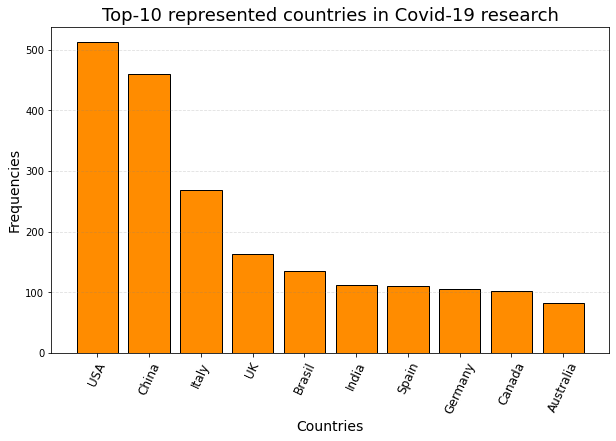

In [20]:
# Plot best represented countries
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize=(10,6))

pos = np.arange(10)

ax = plt.axes()
ax.set_xticks(pos)
ax.set_xticklabels(countries_freq.index[:10], fontsize=12)
plt.xticks(rotation=65, fontsize=12)
plt.bar(pos, countries_freq.values[:10] , edgecolor='black', color = "darkorange")
plt.xlabel('Countries', size=14)
plt.ylabel('Frequencies', size=14)
plt.grid(axis = "y", alpha = 0.25, color = 'grey', linestyle = "--")
plt.title('Top-10 represented countries in Covid-19 research', size=18)
plt.show()
fig.savefig("topcountries.pdf", transparent = True,  bbox_inches = 'tight', pad_inches = 0)

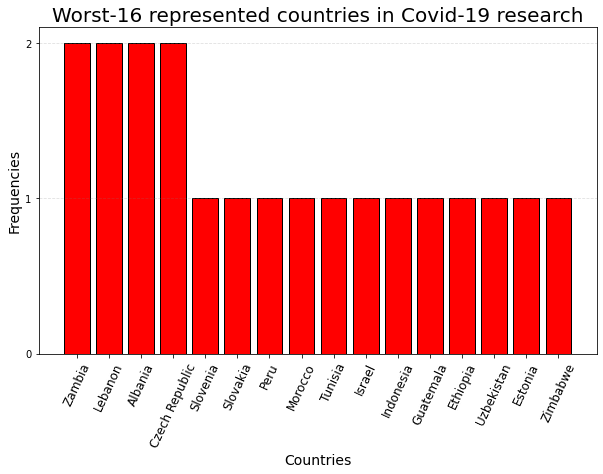

In [19]:
# Plot worst represented countries
fig = plt.figure(figsize=(10,6))

m = 16 # number of countries to display
pos = np.arange(m)

ax = plt.axes()
ax.set_xticks(pos)
ax.set_xticklabels(countries_freq.index[-m:])
plt.xticks(rotation=65, fontsize=12)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.bar(pos, countries_freq.values[-m:], color='r', edgecolor='k')
plt.xlabel('Countries', size=14)
plt.ylabel('Frequencies', size=14)
plt.title('Worst-{} represented countries in Covid-19 research'.format(m), size=20)
plt.grid(axis = "y", alpha = 0.25, color = 'grey', linestyle = "--")
plt.show()
fig.savefig("worstcountries.pdf", transparent = True,  bbox_inches = 'tight', pad_inches = 0)

###  Universities that are most and less active in the COVID-19 research

Here we've done the same computations for the universities ( "*institution*" )

In [23]:
%%time
# Count institution's occurence
institution_freq = df.University.value_counts() #.persist()


CPU times: user 8.08 ms, sys: 0 ns, total: 8.08 ms
Wall time: 7.92 ms


In [24]:
%%time
institution_freq = institution_freq.compute()
institution_freq = institution_freq.drop('') # remove empty institutions ("")

CPU times: user 548 ms, sys: 18.1 ms, total: 567 ms
Wall time: 2.01 s


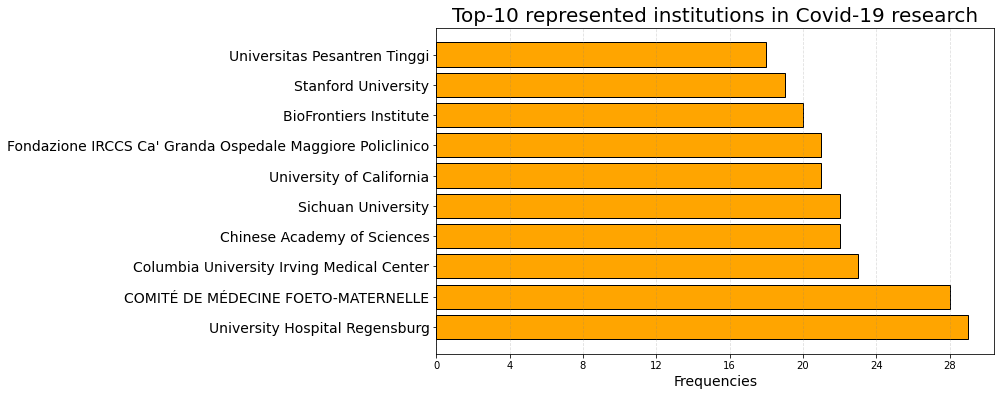

In [30]:
# Plot best represented universities
fig = plt.figure(figsize=(10,6))

pos = np.arange(10)

ax = plt.axes()
ax.set_yticks(pos)
ax.set_yticklabels(institution_freq.index[:10], size = 14)
#plt.yticks(rotation=65)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.barh(pos, institution_freq.values[:10], color='orange', edgecolor='k')
#plt.xlabel('Countries', size=16)
plt.xlabel('Frequencies', size=14)
plt.title('Top-10 represented institutions in Covid-19 research', size=20)
plt.grid(axis = "x", alpha = 0.25, color = 'grey', linestyle = "--")
plt.show()
fig.savefig("topuni.pdf", transparent = True,  bbox_inches = 'tight', pad_inches = 0)

In [31]:
# Print worst institutions
worst_institution = list(institution_freq[institution_freq==1].index)
print('\nWorst institutions --> only 1 paper  (',len(worst_institution),'INSTITUTIONS )\n' )
worst_institution



Worst institutions --> only 1 paper  ( 468 INSTITUTIONS )



['University of Lyon',
 'University of Maryland',
 'University of Manouba',
 'Brandon University',
 'Kyungpook National University',
 'Beijing Normal University',
 'University of Missouri-Columbia',
 'Boston College',
 'BluePearl Veterinary Partners',
 'University of London',
 'Brown University',
 'Beijing Institute of Radiation Medicine',
 'University of Nebraska Medical Center',
 'University of Liège',
 'University of Liverpool',
 'University of New',
 'University of Leicester',
 'Beyond Antibody',
 'University of Massachusetts Amherst',
 'Klinikum Garmisch-Partenkirchen',
 'University of Michigan Medical School',
 'Birjand University of Medical Sciences',
 'Hospital Universitario Central de Asturias',
 'University of Minnesota',
 'King Saud Bin Abdulaziz University for Health Sciences',
 'University of Milano-Bicocca',
 'University of Milano',
 'Boston University',
 'Kuwait Institute for Scientific Research',
 'Bill and Melinda Gates Foundation',
 'University of Lausanne',
 'Kinjo U

In [32]:
#client.close()
dask_close_all()

### 3.2.3 Do multiple runs by changing the number of partitions and workers

One of the most crucial parameters in distributed and parallel computing is the number of partitions in which the dataset is divided. In order to study its effect on the calculation speed, we repeat the analysis shown above by changing the number of partitions.

In [33]:
def compute_time(workers=12, npart=8):
    
    # Create a distributed cluster with as many workers as cores 
    tmpCluster = Cluster(nprocs = workers, 
                         nthreads=1,
                         memory_limit='1GB'
                        )
    client = Client(tmpCluster)
    
    start = time.time()
    
    b = db.read_text('data/papers_in_json_singleline/*.json').map(json.loads).repartition(npartitions=npart)
    
    df = b.pluck('metadata').pluck('authors').flatten().map(dataframe_flatten).to_dataframe()
    
    freq_c1 = df.Country1.value_counts()
    freq_c2 = df.Country2.value_counts()
    freq_c3 = df.Country3.value_counts()
    countries_freq = freq_c1.add(freq_c2, fill_value=0).add(freq_c3, fill_value=0).astype(int)

    institution_freq = df.University.value_counts()
    
    (countries_freq, institution_freq) = dask.compute(countries_freq, institution_freq)
    institution_freq = institution_freq.drop('')
    
    end = time.time()
    
    dask_close_all() # close both client and scheduler 
    
    return (end-start)

In [34]:
parts = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

timings_parts = np.zeros(len(parts))

for p in range(len(parts)):
    timings_parts[p] = compute_time(npart=parts[p])

distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:37772'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:40415'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.111:33733'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:41295'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.254:33222
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.111:33932
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.254:37402
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.254:34242
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.254:46259
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.111:33474
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.111:44093
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.111:45595
distributed

distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.111:44563'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:46057'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:44263'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.111:45736'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:42888'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.111:41469'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.111:45803'
distributed.deploy.ssh - INFO - distributed.n

distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.111:45675
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.254:44721
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.254:34656
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.111:36703
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:39537
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:43868
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:   tcp://10.67.22.111:36273
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:40766
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:44947
distribute

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished ex

In [35]:
for p in range(len(parts)):
    print("Partitions per worker: ", parts[p], "\t time [s]: ", timings_parts[p])

Partitions per worker:  1 	 time [s]:  10.71145486831665
Partitions per worker:  2 	 time [s]:  6.658008575439453
Partitions per worker:  4 	 time [s]:  4.94167685508728
Partitions per worker:  8 	 time [s]:  3.284055709838867
Partitions per worker:  16 	 time [s]:  3.2444794178009033
Partitions per worker:  32 	 time [s]:  3.3245158195495605
Partitions per worker:  64 	 time [s]:  3.31506609916687
Partitions per worker:  128 	 time [s]:  3.222119092941284
Partitions per worker:  256 	 time [s]:  3.761132001876831
Partitions per worker:  512 	 time [s]:  4.66805100440979


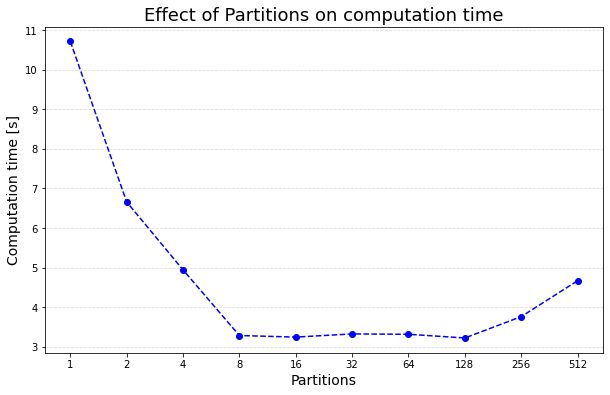

In [40]:
# Bar plot of Time vs Number of partitions

fig = plt.figure(figsize=(10, 6))
plt.plot(range(len(parts)),timings_parts,color = 'blue', marker = "o", linestyle = "--")
plt.title('Effect of Partitions on computation time',size=18)
plt.xlabel('Partitions',size=14)
plt.ylabel('Computation time [s]',size=14)
plt.xticks(range(len(parts)),parts)
plt.grid(axis = "y", alpha = 0.25, color = 'grey', linestyle = "--")
plt.show()
fig.savefig("partitions2.pdf", transparent = True,  bbox_inches = 'tight', pad_inches = 0)

Here we could see how increasing the number of partitions the execution time decreases thanks to parallelization of tasks, but at some point (from *partition = 128* ), the computation time start to increase again. 

<br> As indicated in ***Part 1*** of the notebook, there is a cost to having both too many or too few partitions.

## Grid Search:

In the end, as in the ***Part 1***, we implement a Grid-search by changing the number of workers and the number of partitions for each worker, in order to see the performance of the algorithm as the cluster structure. 

In [41]:
workers = list(range(2,13,2))
parts = [1,4,8,12,16,20,24]

timings = np.zeros((len(workers),len(parts)))

for w in range(len(workers)):
        for p in range(len(parts)):
            timings[w][p] = compute_time(workers[w],parts[p]*workers[w])
            print("workers: ", workers[w], " partitions: ", parts[p]*workers[w], " time [s]: ", timings[w][p])

distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:32881'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:34254'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:37956
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f645cf2b670>>, <Task finished name='Task-4837' coro=<SpecCluster._close() done, defined at /root/anaconda3/lib/python3.8/site-packages/distributed/deploy/spec.py:409> exception=RPCClosed("RPC Closed: while trying to call remote method 'retire_workers'")>)
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.8/site-packages/distributed/core.py", line 789, in send_recv_from_rpc
    comm = await self.live_comm()
  File "/root/anaconda3/lib/python3.8/site-packages/distributed/core.py", line 736, in live_comm
    raise RPCClosed("RPC Closed")
distributed.core.RPCClosed: RPC Closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/roo

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f644ddd5100>>, <Task finished name='Task-4844' coro=<SpecCluster._close() done, defined at /root/anaconda3/lib/python3.8/site-packages/distributed/deploy/spec.py:409> exception=RPCClosed("RPC Closed: while trying to call remote method 'retire_workers'")>)
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.8/site-packages/distributed/core.py", line 789, in send_recv_from_rpc
    comm = await self.live_comm()
  File "/root/anaconda3/lib/python3.8/site-packages/distributed/core.py", line 736, in live_comm
    raise RPCClosed("RPC Closed")
distributed.core.RPCClosed: RPC Closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/roo

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f644e1a1610>>, <Task finished name='Task-4856' coro=<SpecCluster._close() done, defined at /root/anaconda3/lib/python3.8/site-packages/distributed/deploy/spec.py:409> exception=RPCClosed("RPC Closed: while trying to call remote method 'retire_workers'")>)
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.8/site-packages/distributed/core.py", line 789, in send_recv_from_rpc
    comm = await self.live_comm()
  File "/root/anaconda3/lib/python3.8/site-packages/distributed/core.py", line 736, in live_comm
    raise RPCClosed("RPC Closed")
distributed.core.RPCClosed: RPC Closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/roo

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  2  partitions:  2  time [s]:  10.337372779846191


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:40327'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:37722'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:46407
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  2  partitions:  8  time [s]:  7.594159841537476


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:45327'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:39899'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:36877
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  2  partitions:  16  time [s]:  7.159138441085815


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:41347'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:33799'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:44962
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  2  partitions:  24  time [s]:  6.747882127761841


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:36590'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:37366'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:42275
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  2  partitions:  32  time [s]:  6.722581386566162


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:36100'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:36783'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:33306
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  2  partitions:  40  time [s]:  7.43976616859436


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:41632'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:39205'
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker at:    tcp://10.67.22.84:43685
distributed.deploy.ssh - INFO - distributed.worker - INFO -       Start worker

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  2  partitions:  48  time [s]:  7.054484844207764


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:44255'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:34604'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:42816'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny 

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  4  partitions:  4  time [s]:  5.7888875007629395


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:42705'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:39471'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:46642'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny 

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client


workers:  4  partitions:  16  time [s]:  4.565368175506592


_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:35985'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:40291'
distributed.deploy.ssh - INFO - distributed.

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  4  partitions:  32  time [s]:  4.550042152404785


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:40287'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:34983'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:39394'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny 

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  4  partitions:  48  time [s]:  4.619300842285156


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:34816'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:45475'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:40226'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny 

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client


workers:  4  partitions:  64  time [s]:  4.5233354568481445


_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:37455'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:33055'
distributed.deploy.ssh - INFO - distributed.

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  4  partitions:  80  time [s]:  4.623873949050903


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:46567'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:40040'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:39526'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny 

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  4  partitions:  96  time [s]:  4.735281705856323


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:46751'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:39417'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:46732'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nann

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  6  partitions:  6  time [s]:  4.930936098098755


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:38734'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:43936'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:40957'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  6  partitions:  24  time [s]:  4.164644718170166


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:39842'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:40144'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:36268'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nann

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  6  partitions:  48  time [s]:  3.9329733848571777


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:43086'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:43251'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:42280'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nann

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  6  partitions:  72  time [s]:  4.0894834995269775


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:40667'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:46402'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:39215'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nann

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  6  partitions:  96  time [s]:  4.23408842086792


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:33067'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:41309'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:41411'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nann

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  6  partitions:  120  time [s]:  4.292003154754639


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:41228'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.84:33503'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:42149'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nann

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  6  partitions:  144  time [s]:  4.372749090194702


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:42471'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:38865'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:38975'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  8  partitions:  8  time [s]:  3.8699402809143066


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:43184'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:45824'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:37712'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  8  partitions:  32  time [s]:  3.480473041534424


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:43198'
distributed.deploy.ssh - INFO - distributed.nanny - IN

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  8  partitions:  64  time [s]:  3.5896363258361816


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:40672'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:43501'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:46284'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  8  partitions:  96  time [s]:  3.666175365447998


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:45283'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:41721'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:45410'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  8  partitions:  128  time [s]:  3.916480779647827


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:33841'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:38702'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:34177'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  8  partitions:  160  time [s]:  3.913452386856079


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:41821'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:41058'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:38465'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
workers:  8  partitions:  192  time [s]:  4.028810739517212


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:36110'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:33429'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:38961'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

workers:  10  partitions:  10  time [s]:  3.8946871757507324


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - IN

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f644e1fcca0>>, <Task finished name='Task-20924' coro=<SpecCluster._close() done, defined at /root/anaconda3/lib/python3.8/site-packages/distributed/deploy/spec.py:409> exception=RPCClosed("RPC Closed: while trying to call remote method 'retire_workers'")>)
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.8/site-packages/distributed/core.py", line 789, in send_recv_from_rpc
    comm = await self.live_comm()
  File "/root/anaconda3/lib/python3.8/site-packages/distributed/core.py", line 736, in live_comm
    raise RPCClosed("RPC Closed")
distributed.core.RPCClosed: RPC Closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/ro

workers:  10  partitions:  40  time [s]:  3.263291358947754


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:33141'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:37375'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:40661'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

workers:  10  partitions:  80  time [s]:  3.7463579177856445


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:39270'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:37105'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:46014'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

workers:  10  partitions:  120  time [s]:  3.634040117263794


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:39829'
distributed.deploy.ssh - INFO - distributed.nanny - IN

workers:  10  partitions:  160  time [s]:  3.7988154888153076


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:35994'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:41527'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:34647'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

workers:  10  partitions:  200  time [s]:  3.8745999336242676


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:41228'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:39481'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:37833'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

workers:  10  partitions:  240  time [s]:  4.292670011520386


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:39391'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:36030'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:45370'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

workers:  12  partitions:  12  time [s]:  3.2840452194213867


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:33850'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.111:44644'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:40311'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

workers:  12  partitions:  48  time [s]:  2.992988109588623


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.111:45994'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:36104'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.111:45392'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

workers:  12  partitions:  96  time [s]:  3.2062606811523438


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.111:44045'
distributed.deploy.ssh - INFO - distributed.nanny - IN

workers:  12  partitions:  144  time [s]:  3.5666441917419434


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.111:40274'
distributed.deploy.ssh - INFO - distributed.nanny - IN

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f644d5a69d0>>, <Task finished name='Task-32123' coro=<SpecCluster._close() done, defined at /root/anaconda3/lib/python3.8/site-packages/distributed/deploy/spec.py:409> exception=RPCClosed("RPC Closed: while trying to call remote method 'retire_workers'")>)
Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.8/site-packages/distributed/core.py", line 789, in send_recv_from_rpc
    comm = await self.live_comm()
  File "/root/anaconda3/lib/python3.8/site-packages/distributed/core.py", line 736, in live_comm
    raise RPCClosed("RPC Closed")
distributed.core.RPCClosed: RPC Closed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/root/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/ro

workers:  12  partitions:  192  time [s]:  3.508057117462158


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.111:32847'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.111:36900'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:43919'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

workers:  12  partitions:  240  time [s]:  3.899721145629883


distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - -----------------------------------------------
distributed.deploy.ssh - INFO - distributed.scheduler - INFO - Clear task state
distributed.deploy.ssh - INFO - distributed.scheduler - INFO -   Scheduler at:    tcp://10.67.22.84:8786
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.254:37683'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.111:34307'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.111:43206'
distributed.deploy.ssh - INFO - distributed.nanny - INFO -         Start Nan

workers:  12  partitions:  288  time [s]:  3.8733744621276855


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client -

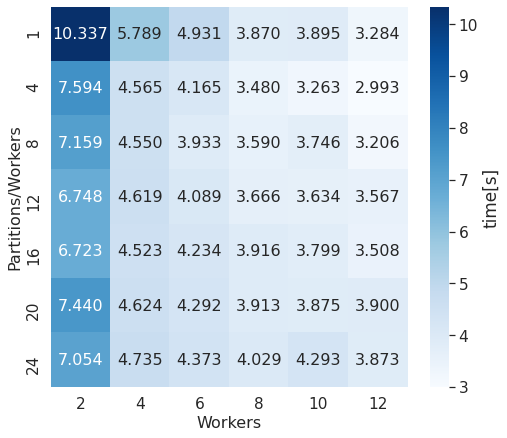

In [43]:
df_cm = pd.DataFrame(timings.T, parts, workers)

fig = plt.figure(figsize=(8,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt=".3f",
           cbar_kws={'label':'time[s]'}, cmap="Blues")
plt.xlabel('Workers', fontsize=16)
plt.ylabel('Partitions/Workers', fontsize=16)
plt.show()
fig.savefig("grid1.pdf", transparent = True,  bbox_inches = 'tight', pad_inches = 0)

We see from the above plot that 12 workers and 12 x 4 = 48 Partitions, are found to be optimal with the smaller computation time. 

***NOTE***: <br>
*We avoid to use a number of workers bigger than the number of cores we have in our cluster, since the workers are supposed to execute tasks in parallel.
If we had used an higher number of workers ( $\geq 12$ in this case), the execution time might increase respect to the same task with workers $\leq$ number of core available.*
